In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preparing Datasets

In [4]:
# import kl_divergence and ks_test functions from utils.py
from scipy.special import kl_div
from scipy.stats import ks_2samp
from sklearn.preprocessing import QuantileTransformer

df_harvard = pd.read_csv('./data/harvard_feature_engineered.csv', sep=';', decimal=',')
df_triage = pd.read_csv('./data/triage_feature_engineered.csv', sep=';', decimal=',')

# only consider records in triage where smoker is 1
# triage_copy = triage_copy[triage_copy['Smoker'] == 1]
# print(triage_copy.shape)

# TODO manually add all the vars that possibly could be used in harmonization
relevant_harvard_vars = [ '% FEV1 b', 'Age', 'Height', 'Weight', 'BMI', 'MMRC', 'Exacerbation', 'GOLD', 'Coronary Artery Disease', 'Gender, Male', 'Diabetes', 'Kidney disease', 'Congestive Heart Failure', 'Hypertension', 'Oxygen Therapy', 'ICU last year', 'Asthma', 'Hospitalized last year', '2+ Exa. last year', 'Daily Inhaler', 'Lives alone', 'Pill to control Exa.', 'Rescue Inhaler', 'Night Symptoms'] #'% FEV1 a',
relevant_triage_vars = ['% FEV1 b',  'Age', 'Height', 'Weight', 'BMI', 'MMRC b', 'Exacerbation', 'GOLD', 'Coronary Artery Disease', 'Gender, Male', 'Diabetes', 'Kidney disease', 'Congestive Heart Failure', 'Hypertension', 'Oxygen Therapy', 'ICU last year', 'Asthma', 'Hospitalized last year', '2+ Exa. last year', 'Daily Inhaler', 'Lives alone', 'Pill to control Exa.', 'Rescue Inhaler', 'Night Symptoms']

# get all columns with the same names in both datasets

df_triage.rename(columns={ 'MMRC b': 'MMRC'}, inplace=True)
shared_columns = list(set(df_harvard.columns).intersection(set(df_triage.columns)))
df_triage = df_triage[shared_columns]
df_harvard = df_harvard[shared_columns]
# print(df_harvard.shape)
# try applying some sort of transformation to different selections of variables


In [5]:
# create a scatter plot of each variable against another variable
variables_to_show = shared_columns
variables_to_show.remove('Exacerbation')
fig, axs = plt.subplots(28, 28, figsize=(150, 150))
for i in range(28):
    for j in range(28):
        if i == j:
            pass
            # # create a list of the current variable and the exacerbation variable
            # subset = df_harvard[[shared_columns[i], 'Exacerbation']]
            # sns.histplot(data=subset, ax=axs[i, j], kde=True, hue='Exacerbation')
            # axs[i, j].set_title(shared_columns[i])
        else:
            axs[i, j].scatter(df_harvard[variables_to_show[i]], df_harvard[variables_to_show[j]], c=df_harvard['Exacerbation'], )
            axs[i, j].set_title(variables_to_show[i] + ' vs ' + variables_to_show[j])

In [ ]:
# train a regressor on the harvard data with triage data as the target
# then use the regressor to predict the triage data
# then compare the predicted triage data to the actual triage data

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# df_harvard_copy = df_harvard.copy()
# df_harvard_copy.fillna(df_harvard_copy.mean(), inplace=True)
# df_triage_copy = df_triage.copy()
# df_triage_copy.fillna(df_triage_copy.mean(), inplace=True)

# X = df_harvard_copy['% FEV1 b'].values.reshape(-1, 1)
# y = df_triage_copy['% FEV1 b'].values.reshape(-1, 1)
# # shorten y symmetrically to match X
# difference = y.shape[0] - X.shape[0]
# y = y[difference//2:-difference//2]


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# regressor = RandomForestRegressor(n_estimators=100, max_depth=10)
# regressor.fit(X_train, y_train)

# y_pred = regressor.predict(X_test)

# # plot histogram of X, y, y_pred
# plt.hist(X, bins=100)
# plt.hist(y, bins=100)
# plt.hist(y_pred, bins=100)

# print(mean_squared_error(y_test, y_pred))

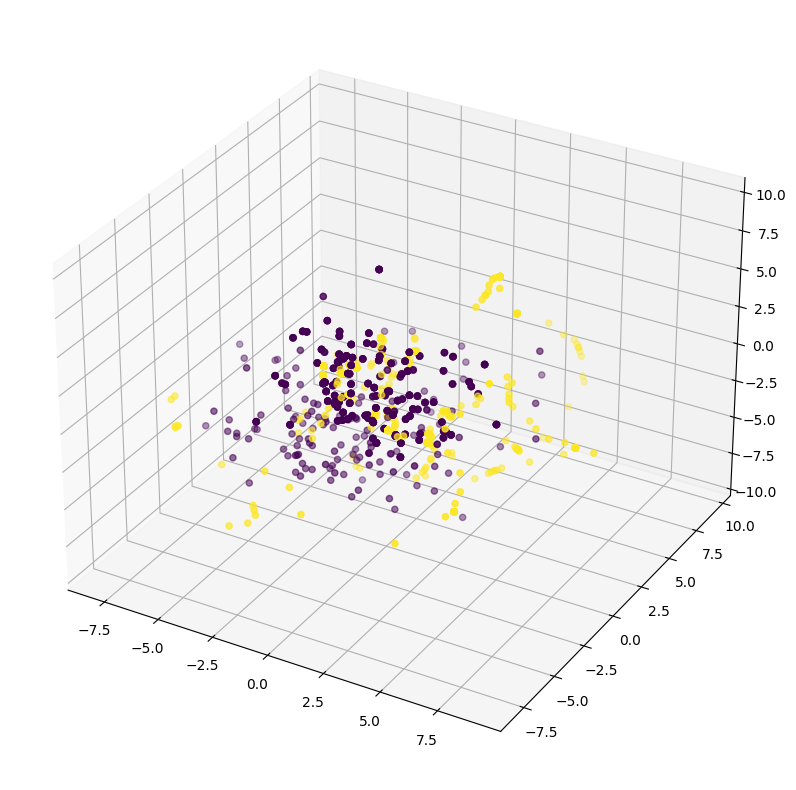

In [112]:
# try dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
import umap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
# pca = PCA(n_components=2)

df_harvard_copy = df_harvard.copy()
df_harvard_copy.fillna(df_harvard_copy.mean(), inplace=True)
df_triage_copy = df_triage.copy()
df_triage_copy.fillna(df_triage_copy.mean(), inplace=True)
X_harvard = df_harvard_copy.drop('Exacerbation', axis=1)
X_triage = df_triage_copy.drop('Exacerbation', axis=1)
y_harvard = df_harvard_copy['Exacerbation']
y_triage = df_triage_copy['Exacerbation']
# Standardize
scaler = StandardScaler()
# quantile_transformer = QuantileTransformer()
X_harvard_scaled = scaler.fit_transform(X_harvard)

# apply smote to harvard data
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_harvard_scaled, y_harvard = smote.fit_resample(X_harvard_scaled, y_harvard)

isomap = Isomap(n_components=3, n_neighbors=2)
X_harvard_transformed = isomap.fit_transform(X_harvard_scaled, y_harvard)
# 3D scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_harvard_transformed[:,0], X_harvard_transformed[:,1], X_harvard_transformed[:,2], c=y_harvard)

# embedding_harvard = umap.UMAP(n_neighbors=15, n_components=3).fit_transform(X_harvard_scaled, y_harvard)
# embedding_triage = umap.UMAP(n_neighbors=15, n_components=3).fit_transform(df_triage_copy, y_triage)

# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import train_test_split

# X_train_harvard, X_test_harvard, y_train_harvard, y_test_harvard = train_test_split(embedding_harvard, y_harvard, test_size=0.2)
# X_train_triage, X_test_triage, y_train_triage, y_test_triage = train_test_split(embedding_triage, y_triage, test_size=0.2)
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# # models_triage, predictions_triage = clf.fit(X_train_triage, X_test_triage, y_train_triage, y_test_triage)
# model_mixed, predictions_mixed = clf.fit(X_train_harvard, X_test_triage, y_train_harvard, y_test_triage)
# model_mixed
# model_mixed2, predictions_mixed2 = clf.fit(X_train_triage, X_test_harvard, y_train_triage, y_test_harvard)

# # create 2D plot
# fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(embedding_harvard[:,0], embedding_harvard[:,1], c=y_harvard)

# fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(embedding_triage[:,0], embedding_triage[:,1], c=y_triage)


# # create 3D scatter plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(embedding_harvard[:,0], embedding_harvard[:,1], embedding_harvard[:,2], c=y_harvard)

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(embedding_triage[:,0], embedding_triage[:,1], embedding_triage[:,2], c=y_triage)

# # pca.fit(X_harvard_scaled)
# # harvard_pca = pca.transform(X_harvard_scaled)
# # print(harvard_pca.shape)
# # plot the scatter plot. Color the points by the class
# plt.scatter(harvard_pca[:,0], harvard_pca[:,1], c=y_harvard)

# fig, ax = plt.subplots(figsize=(10,10))
# # now triage
# X_triage_scaled = scaler.fit_transform(X_triage)

# # pca.fit(X_triage_scaled)
# triage_pca = isomap.fit_transform(X_triage_scaled)
# plt.scatter(triage_pca[:,0], triage_pca[:,1], c=y_triage)

In [ ]:
# try classification

# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

# df_harvard_copy = df_harvard.copy()
# df_harvard_copy.fillna(df_harvard_copy.mean(), inplace=True)
# df_triage_copy = df_triage.copy()
# df_triage_copy.fillna(df_triage_copy.mean(), inplace=True)

# X_train_harvard, X_test_harvard, y_train_harvard, y_test_harvard = train_test_split(df_harvard_copy.drop(columns=['Exacerbation']), df_harvard_copy['Exacerbation'], test_size=0.2, random_state=42)

# X_train_triage, X_test_triage, y_train_triage, y_test_triage = train_test_split(df_triage_copy.drop(columns=['Exacerbation']), df_triage_copy['Exacerbation'], test_size=0.2, random_state=42)

# train a random forest classifier on the harvard data and test on the triage data
# rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
# rf.fit(X_train_harvard, y_train_harvard)
# print(rf.score(X_train_triage, y_train_triage))
# print(rf.score(X_test_triage, y_test_triage))



# Feature Importance

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

target = 'Exacerbation'

discrete_features_triage = df_triage.columns[df_triage.nunique() <= 5].drop(target)
continuous_features_triage = df_triage.columns[df_triage.nunique() > 5]
discrete_features_harvard = df_harvard.columns[df_harvard.nunique() <= 10].drop(target)
continuous_features_harvard = df_harvard.columns[df_harvard.nunique() > 10]


harvard_copy = df_harvard.copy()
triage_copy = df_triage.copy()
triage_copy.dropna(subset=[target], inplace=True)
# only consider smokers
# triage_copy = triage_copy[triage_copy['Smoker'] == 1]
X_harvard = harvard_copy.drop(target, axis=1)
X_triage = triage_copy.drop(target, axis=1)
mutual_info_split_harvard = pd.DataFrame(columns=sorted(X_harvard.columns))
mutual_info_split_triage = pd.DataFrame(columns=sorted(X_triage.columns))
rf_split_harvard = pd.DataFrame(columns=sorted(X_harvard.columns))
rf_split_triage = pd.DataFrame(columns=sorted(X_triage.columns))
# use median to impute NaN values
X_harvard = X_harvard.fillna(X_harvard.median())
# transform back to dataframe
X_harvard = pd.DataFrame(X_harvard, columns=harvard_copy.drop(target, axis=1).columns)
X_triage = X_triage.fillna(X_triage.median())
y_harvard = harvard_copy[target]
y_harvard = LabelEncoder().fit_transform(y_harvard)
y_triage = triage_copy[target]
y_triage = LabelEncoder().fit_transform(y_triage)
for i in range(100):
    # create a train test split to shuffle the data
    X_train_harvard, X_test_harvard, y_train_harvard, y_test_harvard = train_test_split(X_harvard, y_harvard, test_size=0.2, random_state=i)
    X_train_triage, X_test_triage, y_train_triage, y_test_triage = train_test_split(X_triage, y_triage, test_size=0.2, random_state=i)
    # infomation gain processing
    # mutual_info_harvard_discrete = mutual_info_classif(X_train_harvard[discrete_features_harvard], y_train_harvard, random_state=42, discrete_features=True)
    # mutual_info_harvard_continuous = mutual_info_classif(X_train_harvard[continuous_features_harvard], y_train_harvard, random_state=42, discrete_features=False)
    # mutual_info_harvard = np.concatenate((mutual_info_harvard_discrete, mutual_info_harvard_continuous), axis=0)
    mutual_info_harvard = mutual_info_classif(X_train_harvard, y_train_harvard, random_state=42)
    # mutual_info_triage_discrete = mutual_info_classif(X_train_triage[discrete_features_triage], y_train_triage, random_state=42, discrete_features=True)
    # mutual_info_triage_continuous = mutual_info_classif(X_train_triage[continuous_features_triage], y_train_triage, random_state=42, discrete_features=False)
    # mutual_info_triage = np.concatenate((mutual_info_triage_discrete, mutual_info_triage_continuous), axis=0)
    mutual_info_triage = mutual_info_classif(X_train_triage, y_train_triage, random_state=42)
    mutual_info_harvard = pd.DataFrame({'variable': X_harvard.columns, 'importances': mutual_info_harvard})
    mutual_info_triage = pd.DataFrame({'variable': X_triage.columns, 'importances': mutual_info_triage})
    # rf processing
    rf_importances_harvard = RandomForestClassifier(random_state=42).fit(X_train_harvard, y_train_harvard).feature_importances_
    rf_importances_triage = RandomForestClassifier(random_state=42).fit(X_train_triage, y_train_triage).feature_importances_
    rf_importances_harvard_df = pd.DataFrame({'variable': X_harvard.columns, 'importances': rf_importances_harvard})
    rf_importances_triage_df = pd.DataFrame({'variable': X_triage.columns, 'importances': rf_importances_triage})
    # sort by feature names
    mutual_info_harvard = mutual_info_harvard.sort_values('variable')
    mutual_info_triage = mutual_info_triage.sort_values('variable')
    rf_importances_harvard_df = rf_importances_harvard_df.sort_values('variable')
    rf_importances_triage_df = rf_importances_triage_df.sort_values('variable')
    # concat the importances to the dataframe. Keep the column index
    mutual_info_split_harvard = pd.concat([mutual_info_split_harvard, mutual_info_harvard.set_index('variable').T])
    mutual_info_split_triage = pd.concat([mutual_info_split_triage, mutual_info_triage.set_index('variable').T])
    rf_split_harvard = pd.concat([rf_split_harvard, rf_importances_harvard_df.set_index('variable').T])
    rf_split_triage = pd.concat([rf_split_triage, rf_importances_triage_df.set_index('variable').T])

mutual_info_split_harvard_medians = mutual_info_split_harvard.median()
mutual_info_split_triage_medians = mutual_info_split_triage.median()
rf_split_harvard_medians = rf_split_harvard.median()
rf_split_triage_medians = rf_split_triage.median()

# sort the columns according to their medians
mutual_info_split_harvard_medians = mutual_info_split_harvard_medians.sort_values(ascending=False)
mutual_info_split_triage_medians = mutual_info_split_triage_medians.sort_values(ascending=False)
rf_split_harvard_medians = rf_split_harvard_medians.sort_values(ascending=False)
rf_split_triage_medians = rf_split_triage_medians.sort_values(ascending=False)

# sort the columns in the split similarly
mutual_info_split_harvard_sorted = mutual_info_split_harvard[mutual_info_split_harvard_medians.index]
mutual_info_split_triage_sorted = mutual_info_split_triage[mutual_info_split_triage_medians.index]
rf_split_harvard_sorted = rf_split_harvard[rf_split_harvard_medians.index]
rf_split_triage_sorted = rf_split_triage[rf_split_triage_medians.index]

In [33]:
import matplotlib as mpl


modified_triage = ['Increase in sputum',  'Fever', 'Wheezing', 'Worse dyspnea', 'Worse cough']
modified_harvard = ['Night Symptoms', 'Rescue Inhaler', '2+ Exa. last year', 'Lives Alone', 'Daily Inhaler', 'Pill to control Exa.']
naturally_existing_in_both = [var for var in triage_copy if (var in harvard_copy.columns and var not in modified_triage and var not in modified_harvard)]
# append MMRC a, MMRC b and MMRC
naturally_existing_in_both.append('MMRC a')
naturally_existing_in_both.append('MMRC b')
naturally_existing_in_both.append('MMRC')
print(naturally_existing_in_both)

# prevent svg backend from rendering text as paths
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

# create subplots with 4 large figures
fig, axs = plt.subplots(2, 2, figsize=(50, 50))
axs[0,0].set_title('Information Gain Harvard', fontsize=40)
axs[0,0].set_xlabel('Information Gain', fontsize=40)
axs[0,1].set_title('Information Gain Triage', fontsize=40)
axs[0,1].set_xlabel('Information Gain', fontsize=40)
axs[1,0].set_title('Random Forest Feature Importance', fontsize=40)
axs[1,0].set_xlabel('Random Forest Importances', fontsize=40)
axs[1,1].set_title('Random Forest Importances Triage', fontsize=40)
axs[1,1].set_xlabel('Random Forest Feature Importance', fontsize=40)

variables_count_difference = len(harvard_copy.columns) - len(triage_copy)
# add that many variables to the end of the triage dataframes
for i in range(variables_count_difference):
    mutual_info_split_triage_sorted["i "+"empty"] = np.nan
    rf_split_triage_sorted["i "+"empty"] = np.nan

# create a horzontal box plot of all features
sns.boxplot(data=mutual_info_split_harvard_sorted, orient='h', ax=axs[0,0])
sns.boxplot(data=mutual_info_split_triage_sorted, orient='h', ax=axs[0,1])
sns.boxplot(data=rf_split_harvard_sorted, orient='h', ax=axs[1,0])
sns.boxplot(data=rf_split_triage_sorted, orient='h', ax=axs[1,1])

# set the labels containg the word "empty to false"
for i in range(len(mutual_info_split_triage.columns)):
    # get the y_label at this position
    y_label = mutual_info_split_triage_sorted.columns[i]
    # if the label contains the word "empty"
    if "empty" in y_label:
        # set the label to false
        axs[0, 1].get_yticklabels()[i].set_visible(False)
        axs[1, 1].get_yticklabels()[i].set_visible(False)

# highlight all the variables that are also in the other dataset
for i in range(len(mutual_info_split_harvard.columns)):
    if mutual_info_split_harvard_sorted.columns[i] in naturally_existing_in_both:
        axs[0, 0].axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.2, label='Naturally exists in both datasets')
        axs[0, 0].get_yticklabels()[i].set_color("orange")
    if mutual_info_split_harvard_sorted.columns[i] in modified_harvard:
        axs[0, 0].axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2, label='Modified or added for Harvard')
        axs[0, 0].get_yticklabels()[i].set_color("blue")
    if mutual_info_split_harvard_sorted.columns[i] in modified_triage:
        axs[0, 0].axhspan(i - 0.5, i + 0.5, facecolor='green', alpha=0.2, label='Modified or added for Triage')
        axs[0, 0].get_yticklabels()[i].set_color("green")
    if rf_split_harvard_sorted.columns[i] in naturally_existing_in_both:
        axs[1, 0].axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.2, label='Naturally exists in both datasets')
        axs[1, 0].get_yticklabels()[i].set_color("orange")
    if rf_split_harvard_sorted.columns[i] in modified_harvard:
        axs[1, 0].axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2, label='Modified or added for Harvard')
        axs[1, 0].get_yticklabels()[i].set_color("blue")
    if rf_split_harvard_sorted.columns[i] in modified_triage:
        axs[1, 0].axhspan(i - 0.5, i + 0.5, facecolor='green', alpha=0.2, label='Modified or added for Triage')
        axs[1, 0].get_yticklabels()[i].set_color("green")

for i in range(len(mutual_info_split_triage.columns)):
    if mutual_info_split_triage_sorted.columns[i] in naturally_existing_in_both:
        axs[0, 1].axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.2, label='Naturally exists in both datasets')
        axs[0, 1].get_yticklabels()[i].set_color("orange")
    if mutual_info_split_triage_sorted.columns[i] in modified_harvard:
        axs[0, 1].axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2, label='Modified or added for Harvard')
        axs[0, 1].get_yticklabels()[i].set_color("blue")
    if mutual_info_split_triage_sorted.columns[i] in modified_triage:
        axs[0, 1].axhspan(i - 0.5, i + 0.5, facecolor='green', alpha=0.2, label='Modified or added for Triage')
        axs[0, 1].get_yticklabels()[i].set_color("green")
    if rf_split_triage_sorted.columns[i] in naturally_existing_in_both:
        axs[1, 1].axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.2, label='Naturally existing in both datasets')
        axs[1, 1].get_yticklabels()[i].set_color("orange")
    if rf_split_triage_sorted.columns[i] in modified_harvard:
        axs[1, 1].axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2, label='Modified or added for Harvard')
        axs[1, 1].get_yticklabels()[i].set_color("blue")
    if rf_split_triage_sorted.columns[i] in modified_triage:
        axs[1, 1].axhspan(i - 0.5, i + 0.5, facecolor='green', alpha=0.2, label='Modified or added for Triage')
        axs[1, 1].get_yticklabels()[i].set_color("green")

# create one legend for the whole figure with labels 'Feature naturally existing in both datasets', 'Feature modified in or added to Harvard', 'Feature modified in or added to Triage'
desired_labels = ['Modified or added for Harvard', 'Modified or added for Triage', 'Naturally exists in both datasets']
all_handles, all_labels = axs[0, 0].get_legend_handles_labels()

# Create dictionaries to store desired handles and labels
custom_handles_dict = {}
custom_labels_dict = {}

for handle, label in zip(all_handles, all_labels):
    if label in desired_labels:
        custom_handles_dict[label] = handle
        custom_labels_dict[label] = label

# Create a custom legend with only the desired labels and handles
custom_handles = [custom_handles_dict[label] for label in desired_labels]
custom_labels = [custom_labels_dict[label] for label in desired_labels]

# set font size of the x and y ticks
for ax in axs.flat:
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=25)

# make sure legend is under the figures
fig.legend(custom_handles, custom_labels, loc='lower right', fontsize=40)
fig.tight_layout()
plt.savefig('all_feature_importances_2.svg', format='svg', dpi=1200, )
plt.show()

['Hospitalized last year', 'Exacerbation', 'Kidney disease', '% FEV1 b', 'Gender, Male', 'Weight', 'Age', 'Oxygen Therapy', 'Diabetes', 'Coronary Artery Disease', 'Height', 'ICU last year', '% FEV1 a', 'Asthma', 'Congestive Heart Failure', 'GOLD', 'BMI', 'Hypertension', 'MMRC a', 'MMRC b', 'MMRC']


KeyboardInterrupt: 

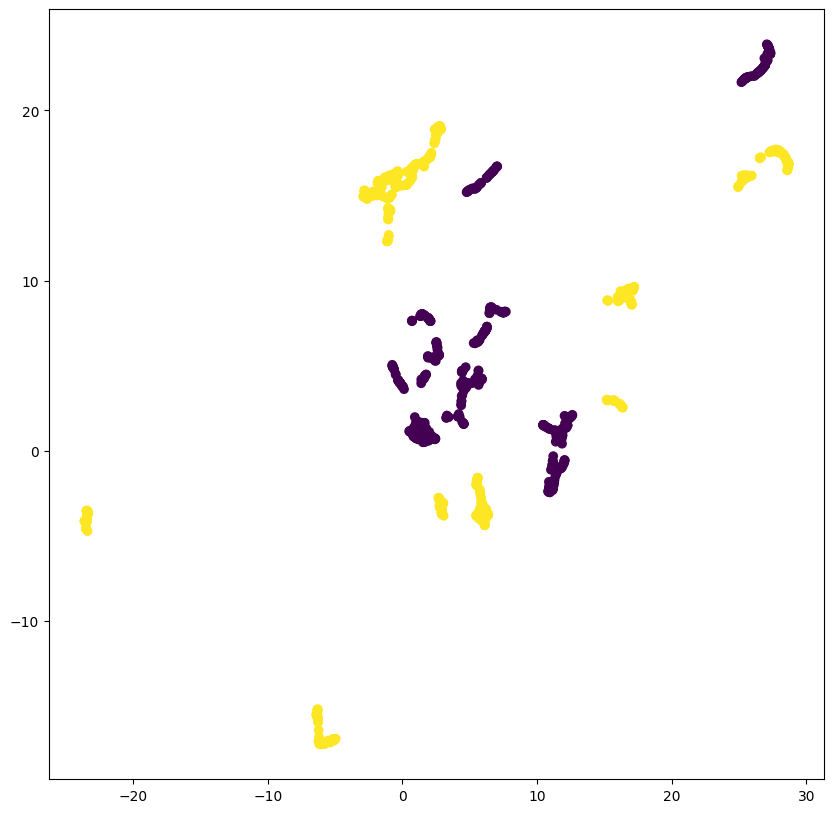

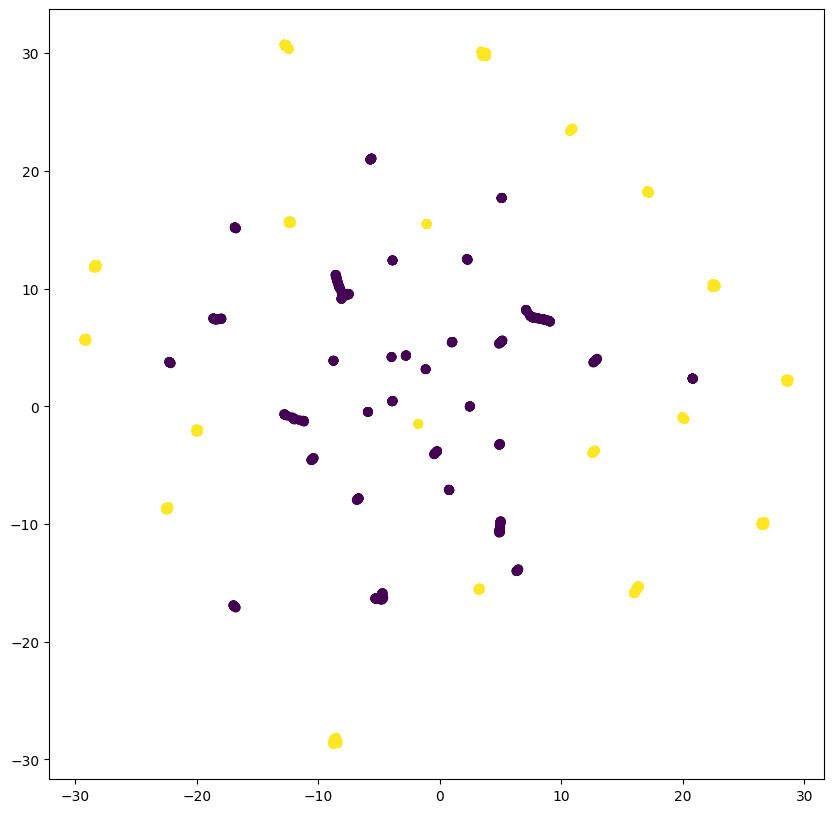

In [20]:
from sklearn.decomposition import PCA
import umap
from imblearn.over_sampling import SMOTE

candidate_values = ['% FEV1 b', 'Age', 'Exacerbation'] #'BMI', 'Weight', 'GOLD'
features = ['% FEV1 b', 'Age']
df_triage_copy = df_triage.copy()
df_triage_copy.fillna(df_triage_copy.mean(), inplace=True)
df_harvard_copy = df_harvard.copy()
df_harvard_copy.fillna(df_harvard_copy.mean(), inplace=True)
subset_triage = df_triage_copy[candidate_values]
subset_harvard = df_harvard_copy[candidate_values]

smote = SMOTE()
subset_triage, y_triage = smote.fit_resample(subset_triage, subset_triage['Exacerbation'])
subset_triage = pd.DataFrame(subset_triage, columns=candidate_values)
subset_triage['Exacerbation'] = y_triage

subset_harvard, y_harvard = smote.fit_resample(subset_harvard, subset_harvard['Exacerbation'])
subset_harvard = pd.DataFrame(subset_harvard, columns=candidate_values)
subset_harvard['Exacerbation'] = y_harvard

# embedding = umap.UMAP(n_neighbors=10).fit_transform(subset_triage, y=subset_triage['Exacerbation'])
# plt.scatter(*embedding.T, c=subset_triage['Exacerbation'], cmap='Spectral', alpha=1.0)

# # apply quantile transformation to the data
# quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42)
# subset_triage[features] = quantile_transformer.fit_transform(subset_triage[features])
# subset_harvard[features] = quantile_transformer.fit_transform(subset_harvard[features])
# # back to pandas
# subset_triage = pd.DataFrame(subset_triage, columns=candidate_values)
# subset_harvard = pd.DataFrame(subset_harvard, columns=candidate_values)

# pca = PCA(n_components=2)
# pca.fit(subset_triage[features])
# subset_triage_transformed = pca.transform(subset_triage[features])
# # add exacerbations back
# subset_triage_transformed = pd.DataFrame(subset_triage_transformed, columns=['PC1', 'PC2'], index=subset_triage.index)
# subset_triage_transformed['Exacerbation'] = subset_triage['Exacerbation']

# pca = PCA(n_components=2)
# pca.fit(subset_harvard[features])
# subset_harvard_transformed = pca.transform(subset_harvard[features])
# subset_harvard_transformed = pd.DataFrame(subset_harvard_transformed, columns=['PC1', 'PC2'], index=subset_harvard.index)
# subset_harvard_transformed['Exacerbation'] = subset_harvard['Exacerbation']

subset_triage_transformed = umap.UMAP(n_neighbors=20, n_components=2).fit_transform(subset_triage, y=subset_triage['Exacerbation'])
subset_harvard_transformed = umap.UMAP(n_neighbors=20, n_components=2).fit_transform(subset_harvard, y=subset_harvard['Exacerbation'])
# back to dataframe
subset_triage_transformed = pd.DataFrame(subset_triage_transformed, columns=['PC1', 'PC2'], index=subset_triage.index)
subset_triage_transformed['Exacerbation'] = subset_triage['Exacerbation']
subset_harvard_transformed = pd.DataFrame(subset_harvard_transformed, columns=['PC1', 'PC2'], index=subset_harvard.index)
subset_harvard_transformed['Exacerbation'] = subset_harvard['Exacerbation']

# create 2D plot
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(subset_triage_transformed['PC1'], subset_triage_transformed['PC2'], c=subset_triage_transformed['Exacerbation'])

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(subset_harvard_transformed['PC1'], subset_harvard_transformed['PC2'], c=subset_harvard_transformed['Exacerbation'])

# # create 3D scatter plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(subset_triage_transformed['PC1'], subset_triage_transformed['PC2'], subset_triage_transformed['PC3'], c=subset_triage_transformed['Exacerbation'])

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(subset_harvard_transformed['PC1'], subset_harvard_transformed['PC2'], subset_harvard_transformed['PC3'], c=subset_harvard_transformed['Exacerbation'])


# pca = PCA(n_components=3)
# pca.fit(subset_harvard[features])
# subset_harvard_transformed = pca.transform(subset_harvard[features])
# # add exacerbations back
# subset_harvard_transformed = pd.DataFrame(subset_harvard_transformed, columns=['PC1', 'PC2', 'PC3'], index=subset_harvard.index)
# subset_harvard_transformed['Exacerbation'] = subset_harvard['Exacerbation']


# print na
# print(subset_triage.isna().sum())
# print(subset_harvard.isna().sum())

# X_train_harvard, X_test_harvard, y_train_harvard, y_test_harvard = train_test_split(subset_harvard_transformed.drop(columns=['Exacerbation']), subset_harvard_transformed['Exacerbation'], test_size=0.2, random_state=42)

# X_train_triage, X_test_triage, y_train_triage, y_test_triage = train_test_split(subset_triage_transformed.drop(columns=['Exacerbation']), subset_triage_transformed['Exacerbation'], test_size=0.2, random_state=42)

# from lazypredict.Supervised import LazyClassifier
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train_triage, X_test_harvard, y_train_triage, y_test_harvard)
# print(models)

# Investigating similarities

In [ ]:
similarities = pd.DataFrame(index = shared_columns, columns = ['KS_Total', 'KS_Exa', 'KS_No_Exa'])
# for each pair of features calculate Kolmogorov-Smirnov
for var in shared_columns:
    ks_total = ks_2samp(triage_copy[var], harvard_copy[var])
    ks_exa = ks_2samp(triage_copy[triage_copy['Exacerbation'] == 1][var], harvard_copy[harvard_copy['Exacerbation'] == 1][var])
    ks_no_exa = ks_2samp(triage_copy[triage_copy['Exacerbation'] == 0][var], harvard_copy[harvard_copy['Exacerbation'] == 0][var])
    similarities.loc[var] = [ks_total[0], ks_exa[0], ks_no_exa[0]]

print(similarities)

# harvard
# numeric_cols = df_harvard_preprocessed.columns[df_harvard_preprocessed.nunique() > 2]


fig, axs = plt.subplots(6, 6, figsize=(100, 100))
# plot the histogram of each variable
row, col = 0, 0
for var in sorted(shared_columns):
    if var == 'Exacerbation':
        continue
    # if we are at the end of the row, move to the next row
    if col == 6:
        row += 1
        col = 0
    # create 
    subset = harvard_copy[[var, 'Exacerbation']]
    # add a row called label
    sns.histplot(subset, x=var, hue='Exacerbation', ax=axs[row, col], kde=True)
    # add a bar for the mean of each group
    axs[row, col].axvline(subset[subset['Exacerbation'] == 0][var].mean(), color='blue', linestyle='dashed', linewidth=5, label='No Exacerbation')
    axs[row, col].axvline(subset[subset['Exacerbation'] == 1][var].mean(), color='orange', linestyle='dashed', linewidth=5, label='Exacerbation')
    # set title
    axs[row, col].set_title(var)
    # add legend
    axs[row, col].legend(loc='upper right')
    # move to the next column
    col += 1

# set name harvard
fig.suptitle('Harvard', fontsize=16)
# save the figure as svg
plt.savefig('./dist/harvard_similar_cols.svg', format='svg', dpi=1200)

fig, axs = plt.subplots(6, 6, figsize=(100, 100))
# plot the histogram of each variable
row, col = 0, 0
for var in sorted(shared_columns):
    if var == 'Exacerbation':
        continue
    # if we are at the end of the row, move to the next row
    if col == 6:
        row += 1
        col = 0
    # create 
    subset = triage_copy[[var, 'Exacerbation']]
    # add a row called label
    sns.histplot(subset, x=var, hue='Exacerbation', ax=axs[row, col], kde=True)
    # add a bar for the mean of each group
    axs[row, col].axvline(subset[subset['Exacerbation'] == 0][var].mean(), color='blue', linestyle='dashed', linewidth=5, label='No Exacerbation')
    axs[row, col].axvline(subset[subset['Exacerbation'] == 1][var].mean(), color='orange', linestyle='dashed', linewidth=5, label='Exacerbation')
    # set title
    axs[row, col].set_title(var)
    # add legend
    axs[row, col].legend(loc='upper right')
    # move to the next column
    col += 1

# set name triage
# fig.suptitle('Triage', fontsize=16)
# save the figure as svg
plt.savefig('./dist/triage_shared_cols.svg', format='svg', dpi=1200)


# turn them back into a dataframe using the previous columns
triage_copy = pd.DataFrame(triage_copy, columns=shared_columns)
harvard_copy = pd.DataFrame(harvard_copy, columns=shared_columns)

# now get similarities again
similarities = pd.DataFrame(index = shared_columns, columns = ['KS_Total', 'KS_Exa', 'KS_No_Exa'])

# for each pair of features calculate Kolmogorov-Smirnov
for var in shared_columns:
    ks_total = ks_2samp(triage_copy[var], harvard_copy[var])
    ks_exa = ks_2samp(triage_copy[triage_copy['Exacerbation'] == 1][var], harvard_copy[harvard_copy['Exacerbation'] == 1][var])
    ks_no_exa = ks_2samp(triage_copy[triage_copy['Exacerbation'] == 0][var], harvard_copy[harvard_copy['Exacerbation'] == 0][var])
    similarities.loc[var] = [ks_total[0], ks_exa[0], ks_no_exa[0]]

# export to csv
similarities.to_csv('similarities.csv', sep=";")

# plot
fig, axs = plt.subplots(6, 6, figsize=(100, 100))
# plot the histogram of each variable
row, col = 0, 0
for var in sorted(shared_columns):
    if var == 'Exacerbation':
        continue
    # if we are at the end of the row, move to the next row
    if col == 6:
        row += 1
        col = 0
    # create subset using index
    subset = harvard_copy[[var, 'Exacerbation']]
    # add a row called label
    sns.histplot(subset, x=var, hue='Exacerbation', ax=axs[row, col], kde=True)
    # add a bar for the mean of each group
    axs[row, col].axvline(subset[subset['Exacerbation'] == 0][var].mean(), color='blue', linestyle='dashed', linewidth=5, label='No Exacerbation')
    axs[row, col].axvline(subset[subset['Exacerbation'] == 1][var].mean(), color='orange', linestyle='dashed', linewidth=5, label='Exacerbation')
    # set title
    axs[row, col].set_title(var)
    # add legend
    axs[row, col].legend(loc='upper right')
    # move to the next column
    col += 1

# set name harvard transformed
fig.suptitle('Harvard Transformed', fontsize=16)
# save the figure as svg
plt.savefig('./dist/harvard_shared_cols_transformed.svg', format='svg', dpi=1200)

fig, axs = plt.subplots(6, 6, figsize=(100, 100))
# plot the histogram of each variable
row, col = 0, 0
for var in sorted(shared_columns):
    if var == 'Exacerbation':
        continue
    # if we are at the end of the row, move to the next row
    if col == 6:
        row += 1
        col = 0
    # create 
    subset = triage_copy[[var, 'Exacerbation']]
    # add a row called label
    sns.histplot(subset, x=var, hue='Exacerbation', ax=axs[row, col], kde=True)
    # add a bar for the mean of each group
    axs[row, col].axvline(subset[subset['Exacerbation'] == 0][var].mean(), color='blue', linestyle='dashed', linewidth=5, label='No Exacerbation')
    axs[row, col].axvline(subset[subset['Exacerbation'] == 1][var].mean(), color='orange', linestyle='dashed', linewidth=5, label='Exacerbation')
    # set title
    axs[row, col].set_title(var)
    # add legend
    axs[row, col].legend(loc='upper right')
    # move to the next column
    col += 1

# set name triage transformed
fig.suptitle('Triage Transformed', fontsize=16)
# save the figure as svg
plt.savefig('./dist/triage_shared_cols_transformed.svg', format='svg', dpi=1200)



print("----------------")
print(similarities)

# Cycle GAN

In [ ]:
# import pandas as pd
# from keras.optimizers import Adam
# from keras.initializers import RandomNormal
# from keras.models import Model
# from tensorflow.keras.layers import Input
# from keras.layers import Conv1D
# from keras.layers import LeakyReLU
# from keras.layers import Activation
# from keras.layers import Concatenate
# from keras.layers import BatchNormalization
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# from keras.utils.vis_utils import plot_model

In [ ]:
# # https://github.com/shreyas253/CycleGAN_1dCNN/tree/master


# # shape of the vector is 29x1

# # define the discriminator model
# def define_discriminator(image_shape):
#     # weight initialization
#     init = RandomNormal(stddev=0.02)
#     # source image input
#     in_image = Input(shape=image_shape)
#     # C64
#     d = Conv1D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
#     d = LeakyReLU(alpha=0.2)(d)
#     # C128
#     d = Conv1D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
#     d = InstanceNormalization(axis=-1)(d)
#     d = LeakyReLU(alpha=0.2)(d)
#     # C256
#     d = Conv1D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
#     d = InstanceNormalization(axis=-1)(d)
#     d = LeakyReLU(alpha=0.2)(d)
#     # C512
#     d = Conv1D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
#     d = InstanceNormalization(axis=-1)(d)
#     d = LeakyReLU(alpha=0.2)(d)
#     # second last output layer
#     d = Conv1D(512, (4,4), padding='same', kernel_initializer=init)(d)
#     d = InstanceNormalization(axis=-1)(d)
#     d = LeakyReLU(alpha=0.2)(d)
#     # patch output
#     patch_out = Conv1D(1, (4,4), padding='same', kernel_initializer=init)(d)
#     # define model
#     model = Model(in_image, patch_out)
#     # compile model
#     model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
#     return model
 
# # define image shape
# image_shape = (256,256,3)
# # create the model
# model = define_discriminator(image_shape)
# # summarize the model
# model.summary()
# # plot the model
# plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)